# Model Development

In developing the optimal model for the task. It is prudent to understand the underlying use case of the model.    
If we exclude the model from the equation and consider from a business perspective what a failure and success look like.   
Then we can choose a model that best suits this purpose.  

For the data are two paths we go do down in with the model.  

- Score importance - Predicting the correct value is most important. The business value is derived from the optimal prediction.
- Business optimisation - Behavioural change and interpretation. How to best improve the quality of the wine? What levers can be pulled?

As an example of a scenario where accuracy is most important. Consider an investor looking to purchase a stake in a winery who had access to this data and the data of the winery. If the price of the stock was closely correlated with the outcome of the given rating (say because of expected demand and associated revenues). A predictive model could be used to optimise the accuracy of the model and feed the outcome into revenue and stock price valuations. To the agent, the drivers of the model are not as important as the prediction. In this case, efforts should be focused on squeezing the most performance out of the model as the most important characteristic is the accuracy of the stock price prediction. Examples of methods that could be used to optimise performance are PCA as a preprocesser, meta ensembling (stacking) for traditional ML, or Neural Networks with Deeper feature spaces with more intensive  architectures, optimisers and schedulers. These models typically have higher accuracy (otherwise use the model with the best accuracy), however, they are often difficult to interpret and maintain.

For most businesses, the typical use case is in process optimisation. In this case, knowing what the outcome will be is as important as the interpretetion. In these scenarios, most effort should go into understanding the causality and the interpretability of the dependent variable, not just the prediction. Further, understanding how business processes can be modified to best improve the quality of the product is also of importance.

In this case the notebook will focus on the second scenario and optimise performance but not at the loss of interpretability.

Start with the usual imports

In [1]:
#Standard lib
import numpy as np
import pandas as pd
import pathlib

#Feat engineering helper func
from helper_funcs.feature_engineering import split_df
from helper_funcs.interpretation import prettified_confusion, plot_learning_curve

#Model creation and analyis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss
from sklearn.externals import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

#Vis
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('default')

C:\Users\lubennett\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Read in the training data and create the training and validation sets.

In [2]:
data_path = pathlib.Path().cwd() / "data" /  "stratified_sets" /"train.csv"
df_raw = pd.read_csv(data_path,low_memory = False)

np.random.seed(2)
perm = np.random.permutation(df_raw.shape[0])
train_size = int(df_raw.shape[0] * 0.8)
train_idx = perm[:train_size]
test_idx = perm[train_size:]
X_train, y_train, X_valid, y_valid = split_df(df_raw, train_idx,test_idx,y_var = "quality")

### Baseline Model

Before we move onto testing and creating a model. We can create a baseline model that will predict the model using a heuristic. This should be a simple rule that one could use if they didn't have a ML algorithm.   
This will give us something to base out ML models against. If the machine learning model can't outperform a heuristic, then it is a pretty good sign the model is not robust enough for the task.  

To create the heuristic, the class can be sampled from the probability of the event occurring in the training and validation sets. Given the events are mutually exclusive, this can be done by taking the value counts and dividing by the total sample size.

In [3]:
baseline = (df_raw.quality.value_counts() / df_raw.shape[0]).sort_index(); baseline

3    0.006254
4    0.033356
5    0.425990
6    0.398888
7    0.124392
8    0.011119
Name: quality, dtype: float64

Using the probabilities, we can create a prediction by using a random choice with the probability of each class from the percentage frequency. To calculate the cross entropy error, we need to calculate the probabilities. In this case this is fixed so we can just replicate the probabilities for each validation sample

In [4]:
np.random.seed(2)
y_bl_predict = np.random.choice(a = baseline.index, size = y_valid.shape[0], p = baseline.values)
baseline_probs = [list(baseline)] * y_bl_predict.shape[0]

We can then calculate the accuracy and cross entropy error.

In this case we correctly predicted the right outcome 37% of the time with a log loss error of 1.19. So overall not a good model.

In [5]:
print(f"Accuracy: {accuracy_score(y_valid,y_bl_predict).round(4) * 100}%")
print(f"Log Loss: {log_loss(y_valid,baseline_probs)}")

Accuracy: 37.15%
Log Loss: 1.1895760796003267


The confusion matrix

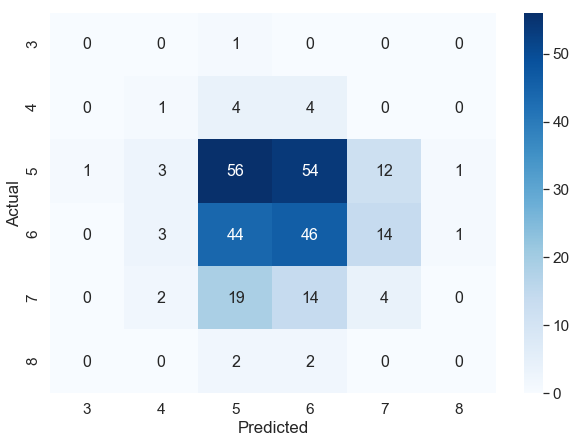

In [6]:
prettified_confusion(y_valid,y_bl_predict, labels = [3,4,5,6,7,8])

### Model Exploration

According to the No free lunch theorem (see https://ti.arc.nasa.gov/m/profile/dhw/papers/78.pdf). There is no one best model that will work on all data sets. As such it is often best to explore the models available and determine which models work best for the given data set.

In this case we can try a series of models and select the one that works best. In the basic comparison we simply use a untuned model to reduce computational complexity 

- KNeighborsClassifier with k = 3
- LogisticRegression
- DecisionTreeClassifier
- RandomForestClassifier
- AdaBoostClassifier
- GradientBoostingClassifier
- GaussianNB
- LinearDiscriminantAnalysis
- QuadraticDiscriminantAnalysis
- XGBClassifier
- Light GBM
    

Lets First import each model

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import xgboost as xgb

We can then create a list of the given models

In [8]:
#Need to add in pipeline components i.e scalers etc As well as define the loss function to be a Softmax
classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    XGBClassifier(),
    LGBMClassifier()]

Some of the models require values to be appropriately scaled. We can do so by using the Standard Scalar function

In [9]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.fit_transform(X_valid)

Looping through the list of classifiers, we can find the accuracy and log loss for each model. and use this to compare the results. 

In [10]:
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    np.random.seed(2)
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    train_predictions = clf.predict(X_valid)
    acc = accuracy_score(y_valid, train_predictions)
    train_predictions = clf.predict_proba(X_valid)
    ll = log_loss(y_valid, train_predictions)
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry);

C:\Users\lubennett\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\lubennett\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


We can now plot the performance of each of the modelsa.  

As expected the boosting algorithms (Gradient Boosting Classifier, Light GBM and XGB) have performed well on this data set. This is to be expected as the class indifferences are relatively strong, particularly in classses 3,4, and 8. For which Boosting can help accomodate for.

We also notice that LGBM performed best in class in accuracy, it had also performed well on the cross entropy. The XGBoost model was best in class in the cross entropy but was slightly behind the GB and LGBM Classifiers in accuracy. Thus suggesting when it was right, it was more confident in its decision. Whilst accuracy is ultimatly the main goal given the ability to use boosted ensembling to reduce errors associated with the high and low class values make the boosting estimators more desirable than the RF classifiers. As such XGBoost is the likely best choice.

In [11]:
log.sort_values("Log Loss")

,Classifier,Accuracy,Log Loss
0,XGBClassifier,61.111111,0.929500
0,LogisticRegression,60.763889,0.943267
0,RandomForestClassifier,63.888889,0.943467
0,LinearDiscriminantAnalysis,57.291667,0.949686
0,GradientBoostingClassifier,60.416667,0.988810
0,LGBMClassifier,62.847222,1.015532
0,GaussianNB,54.861111,1.463722
0,AdaBoostClassifier,55.902778,1.645485
0,QuadraticDiscriminantAnalysis,55.902778,1.986934
0,KNeighborsClassifier,62.152778,7.658466


### Accuracy
Random Forest has performed best in class

Text(0.5, 0, 'Percentage Accuracy')

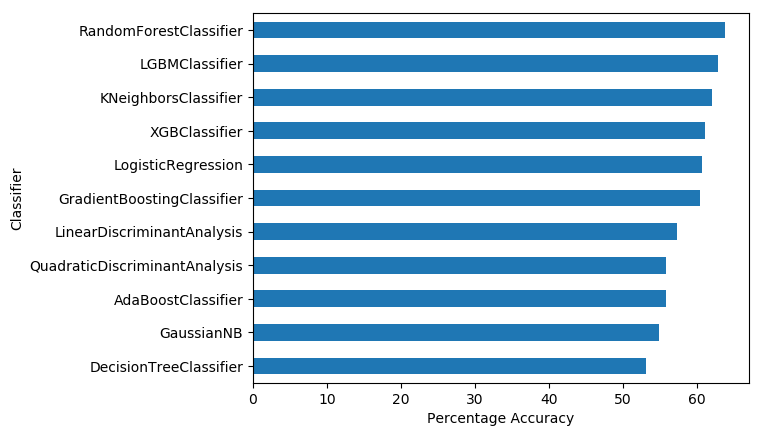

In [12]:
plt.style.use('default')
log.set_index("Classifier")["Accuracy"].sort_values().plot(kind="barh")
plt.xlabel("Percentage Accuracy")

### Cross Entropy  
XGB has performed best in class

Text(0.5, 0, 'Log Loss')

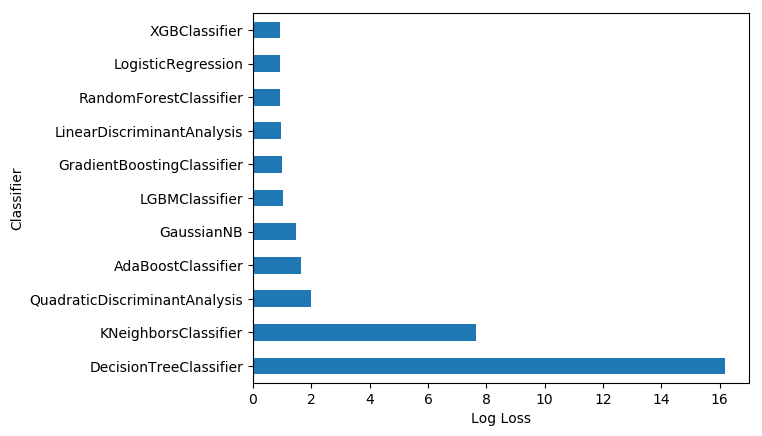

In [13]:
plt.style.use('default')
log.set_index("Classifier")["Log Loss"].sort_values(ascending = False).plot(kind="barh")
plt.xlabel("Log Loss")

# Optimisation of the Model

Now that XGB has been chosen as the model of choice. We can look to improve its performance. 

To optimise the performance, we need to find the hyperparameters that optimise the performance.  
Two potential avenues to do so

 - Discrete Grid Search - RandomizedSearchCV - SKLearn
 - Numerical Optimisation Strategy - Bayesian optimisation - https://github.com/fmfn/BayesianOptimization

### Grid Search
We can look through a discrete set of the values and find the model that minimises the error in the discrete set.  
To do so, we need to provide a discrete set of hyperparameters to the optimiser as well as the model itself.  
For the purposes of this exercise, we can simply use a GridSearchCV from SKLearn

In [14]:
from sklearn.model_selection import GridSearchCV

Define the parameter set

In [15]:
param_grid = {
               "objective": ["multi:softprob"],
               "learning_rate": [0.1, 0.01, 0.001],
               "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "max_depth": [2, 4, 7, 10],
               "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "reg_alpha": [0, 0.5, 1],
               "reg_lambda": [1, 1.5, 2, 3, 4.5],
               "min_child_weight": [1, 3, 5, 7],
               "n_estimators": [100, 250, 500, 1000]
}

Instantiate the gridsearch for the estimator and the grid

In [16]:
model = XGBClassifier()

In [17]:
grid = GridSearchCV(estimator = model,
            param_grid = param_grid, verbose = 0)

Fit the model

In [21]:
grid.fit(X_train, y_train)

In [ ]:
xgb.best_params_

### Testing the performance

In [ ]:
model = XGBClassifier(
    objective = "multi:softprob",
    subsample = 0.7,
    reg_lambda = 1,
    reg_alpha = 0.5,
    n_estimators = 250,
    min_child_weight = 1,
    max_depth = 10,
    learning_rate = 0.01,
    gamma = 0.3,
    colsample_bytree = 0.3)

In [ ]:
model.fit(X_train,y_train)
model.predict(X_valid)
prettified_confusion(y_valid,model.predict(X_valid), labels = [3,4,5,6,7,8])

In [ ]:
model = XGBClassifier(
    objective = "multi:softprob",
    subsample = 0.9,
    reg_lambda = 1,
    reg_alpha = 0.5,
    n_estimators = 250,
    min_child_weight = 2,
    max_depth = 8,
    learning_rate = 0.01,
    gamma = 0.7,
    colsample_bytree = 0.5,
    colsample_bylevel=1,
    eta = 0.08,
    grow_policy = "lossguide",
alpha = 0)

In [ ]:
model.fit(X_train,y_train)

In [ ]:
confusion(y_valid,model.predict(X_valid), labels = [3,4,5,6,7,8])

In [ ]:
accuracy_score(y_valid,model.predict(X_valid))

# Bayesian Optimisation